<a href="https://colab.research.google.com/github/Yfyangd/2019-nCoV/blob/master/X_ray_covid19_SE_ResNet_Ablation_Study_0531.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Library & DataSet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
os.listdir("/content/drive/My Drive/covid19/Xray")

['.DS_Store', 'test', 'val', 'train']

In [0]:
# Import Tensorflow & Keras
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
from keras.utils import to_categorical

import tensorflow as tf

In [3]:
print(os.listdir("/content/drive/My Drive/covid19/Xray/train/"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [0]:
TRAIN_DIR = "../content/drive/My Drive/covid19/Xray/train/"
TEST_DIR =  "../content/drive/My Drive/covid19/Xray/test/"

# 2. Data Preprocess

In [0]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [0]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [0]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [8]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 3876/3876 [47:54<00:00,  1.35it/s]


In [0]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

(Left) - Non_Covid19 Vs (Right) - Covid19
-----------------------------------------------------------------------------------------------------------------------------------


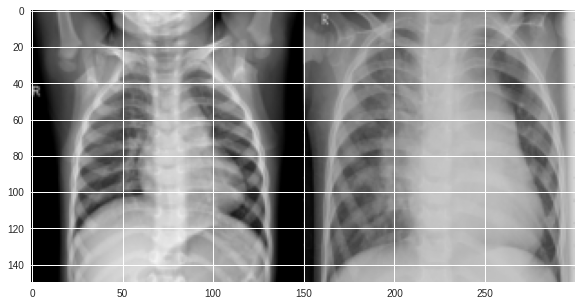

(Left) - Non_Covid19 Vs (Right) - Covid19
-----------------------------------------------------------------------------------------------------------------------------------


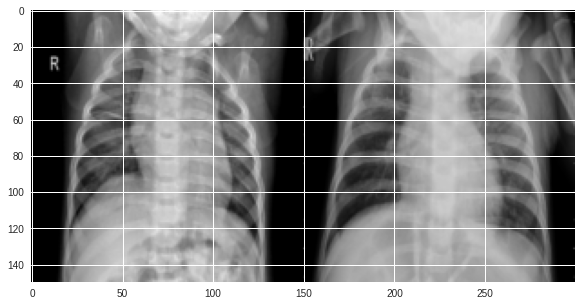

(Left) - Non_Covid19 Vs (Right) - Covid19
-----------------------------------------------------------------------------------------------------------------------------------


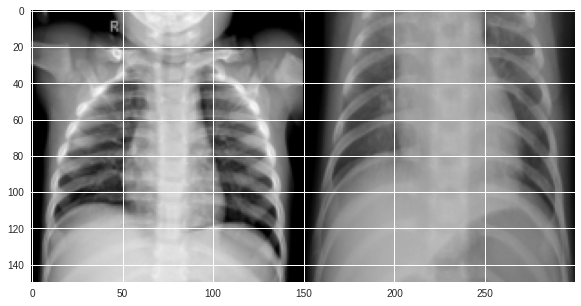

(Left) - Non_Covid19 Vs (Right) - Covid19
-----------------------------------------------------------------------------------------------------------------------------------


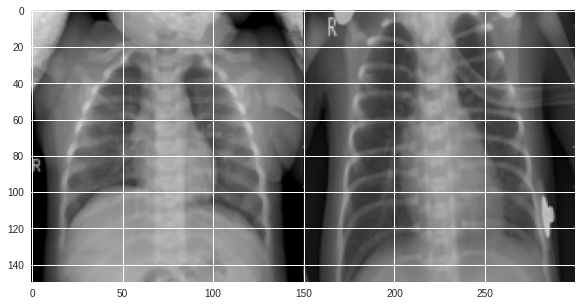

(Left) - Non_Covid19 Vs (Right) - Covid19
-----------------------------------------------------------------------------------------------------------------------------------


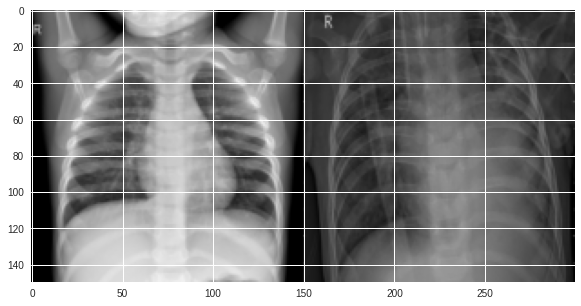

In [51]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - Non_Covid19 Vs (Right) - Covid19")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

# 3. Model Design-SEResNet

## 3.1 Squeeze and Excitation

In [0]:
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = init._keras_shape[-1]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = multiply([init, se])
    return x

## 3.2 ResNet

In [0]:
def resnet_block(input, filters, k=1, strides=(1, 1)):
    init = input
    channel_axis = -1 
    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('relu')(x)
    if strides != (1, 1) or init._keras_shape[channel_axis] != filters * k:
        init = Conv2D(filters * k, (1, 1), padding='same', kernel_initializer='he_normal',use_bias=False, strides=strides)(x)
    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal', use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',use_bias=False)(x)
    # squeeze and excite block
    x = squeeze_excite_block(x)
    m = add([x, init])
    return m

## 3.3 SE_ResNet

In [0]:
def create_se_resnet(classes, img_input, include_top, initial_conv_filters, filters,depth, width, weight_decay, pooling):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    N = list(depth)
    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(img_input)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    for i in range(N[0]):
            x = resnet_block(x, filters[0], width)
    for k in range(1, len(N)):
            x = resnet_block(x, filters[k], width, strides=(2, 2))
    for i in range(N[k] - 1):
            x = resnet_block(x, filters[k], width)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay),activation='softmax')(x)
    return x

## 3.4 Model Summary

In [15]:
img_rows, img_cols = 150, 150
input_shape = (img_rows, img_cols, 3)
initial_conv_filters=64
depth=[2, 2, 2, 2]
filters=[64, 128, 256, 512]
width=1
weight_decay=1e-4
include_top=True
weights=None
input_tensor=None
pooling=None
classes=2

img_input = Input(shape=input_shape)
   
x = create_se_resnet(classes, img_input, include_top, initial_conv_filters,
                          filters, depth, width, weight_decay, pooling)

model = Model(img_input, x, name='resnext')
print('model created')

model.summary()

model created
Model: "resnext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 38, 38, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 38, 38, 64)   256         max_pooling2d_1[0][0]            
______________________________________________________________________________

# 4. Model Training

In [0]:
X_train=X_train.reshape(X_train.shape[0],150,150,3)

In [0]:
y_train = to_categorical(y_train, 2)

In [23]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)

(4172, 150, 150, 3) (1044, 150, 150, 3) (4172, 2) (1044, 2)


In [0]:
filepath = "../content/drive/My Drive/covid19/Xray/SEResNet_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
batch_size = 64
epochs = 10
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
history = model.fit(Xtrain, ytrain, validation_split=0.25, callbacks=[lr_reduce,checkpoint], epochs=epochs)

Train on 3129 samples, validate on 1043 samples
Epoch 1/10
3129/3129 [==============================] - 9s 3ms/step - loss: 0.0252 - accuracy: 0.9958 - val_loss: 0.0680 - val_accuracy: 0.9789
Epoch 2/10
  96/3129 [..............................] - ETA: 5s - loss: 0.0129 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3129/3129 [==============================] - 6s 2ms/step - loss: 0.0174 - accuracy: 0.9984 - val_loss: 0.0610 - val_accuracy: 0.9827
Epoch 3/10
3129/3129 [==============================] - 6s 2ms/step - loss: 0.0184 - accuracy: 0.9971 - val_loss: 0.0609 - val_accuracy: 0.9808
Epoch 4/10
3129/3129 [==============================] - 6s 2ms/step - loss: 0.0173 - accuracy: 0.9978 - val_loss: 0.0609 - val_accuracy: 0.9827
Epoch 5/10
3129/3129 [==============================] - 6s 2ms/step - loss: 0.0202 - accuracy: 0.9968 - val_loss: 0.0610 - val_accuracy: 0.9808
Epoch 6/10
3129/3129 [==============================] - 6s 2ms/step - loss: 0.0157 - accuracy: 0.9990 - val_loss: 0.0608 - val_accuracy: 0.9818
Epoch 7/10
3129/3129 [==============================] - 6s 2ms/step - loss: 0.0221 - accuracy: 0.9974 - val_loss: 0.0699 - val_accuracy: 0.9789
Epoch 8/10
3129/3129 [==============================] - 6s 2ms/step - loss: 0.0205 - accuracy: 0.9958 - val_loss: 0.0598 - val_accuracy: 0.9818
Epo

In [27]:
print(os.listdir("../content/drive/My Drive/covid19/"))

['Xray', 'transferlearning_weights.hdf5', 'inception_v3_weights_notop.h5']


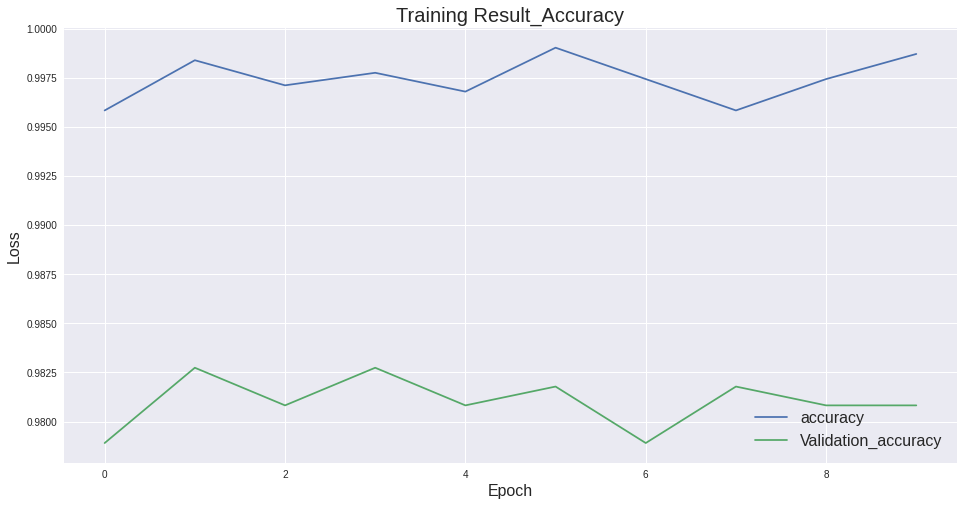

In [33]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Result_Accuracy',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['accuracy','Validation_accuracy'], loc='lower right',fontsize=16)
plt.show()

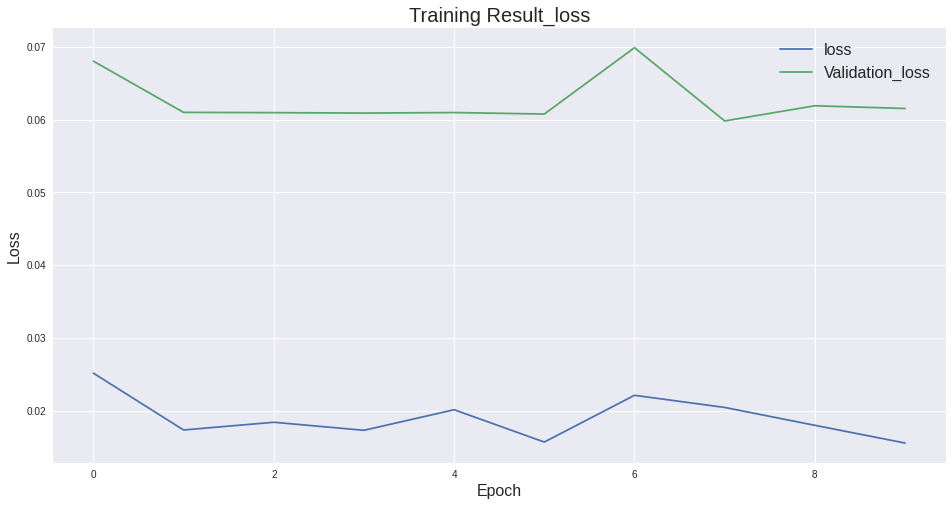

In [34]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Result_loss',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['loss','Validation_loss'], loc='upper right',fontsize=16)
plt.show()

# Test Result
Plot confudion matrix to determine false +ves and false -ves We are using np.argmax since the output will be a 2x1 vector of probabilities and the index chosen is the class label which the model thinks it is the right answer.

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(Xtest)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(ytest,axis = 1)
cls_report = classification_report(y_true, pred)
# print classification report
print("\n\n")
print("-"*50)
print("Report for Transfer Learning Task: ")
print("-"*50)
print(cls_report)
print("-"*50)




--------------------------------------------------
Report for Transfer Learning Task: 
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       270
           1       0.99      0.99      0.99       774

    accuracy                           0.98      1044
   macro avg       0.97      0.97      0.97      1044
weighted avg       0.98      0.98      0.98      1044

--------------------------------------------------


In [0]:
# InceptionV3




--------------------------------------------------
Report for Transfer Learning Task: 
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.81      0.89       270
           1       0.94      0.99      0.96       774

    accuracy                           0.95      1044
   macro avg       0.95      0.90      0.92      1044
weighted avg       0.95      0.95      0.94      1044

--------------------------------------------------


# 5. Ablation Study

## 5.1 Nesterov Adam optimizer

In [47]:
model.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])
batch_size = 64
epochs = 10
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
history = model.fit(Xtrain, ytrain, validation_split=0.25, callbacks=[lr_reduce,checkpoint], epochs=epochs)

Train on 3129 samples, validate on 1043 samples
Epoch 1/10
3129/3129 [==============================] - 11s 4ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1474 - val_accuracy: 0.9607
Epoch 2/10
  96/3129 [..............................] - ETA: 6s - loss: 0.0013 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3129/3129 [==============================] - 7s 2ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3650 - val_accuracy: 0.9175
Epoch 3/10
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2691 - val_accuracy: 0.9367
Epoch 4/10
3129/3129 [==============================] - 7s 2ms/step - loss: 9.1949e-04 - accuracy: 1.0000 - val_loss: 0.2608 - val_accuracy: 0.9406
Epoch 5/10
3129/3129 [==============================] - 7s 2ms/step - loss: 7.9669e-04 - accuracy: 1.0000 - val_loss: 0.2453 - val_accuracy: 0.9434
Epoch 6/10
3129/3129 [==============================] - 7s 2ms/step - loss: 7.6213e-04 - accuracy: 1.0000 - val_loss: 0.6343 - val_accuracy: 0.8773
Epoch 7/10
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.1119 - val_accuracy: 0.9645
Epoch 8/10
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy

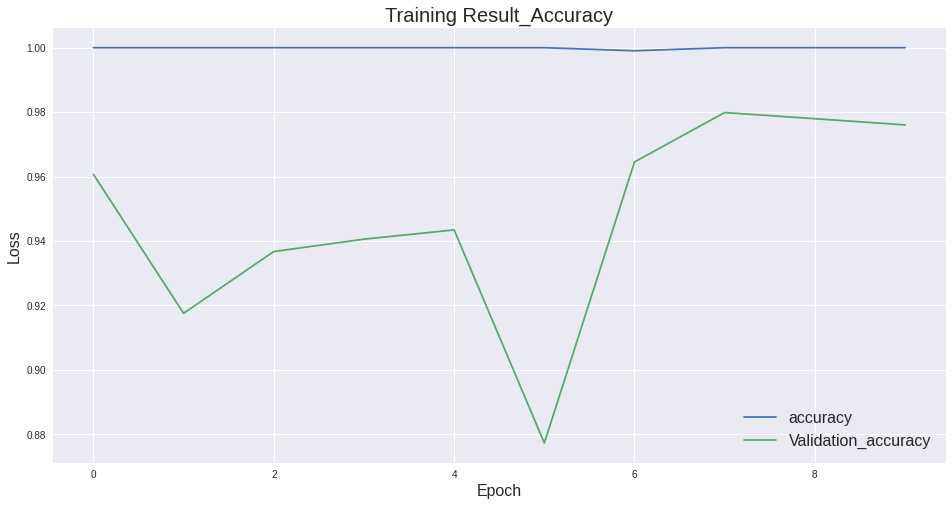

In [48]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Result_Accuracy',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['accuracy','Validation_accuracy'], loc='lower right',fontsize=16)
plt.show()

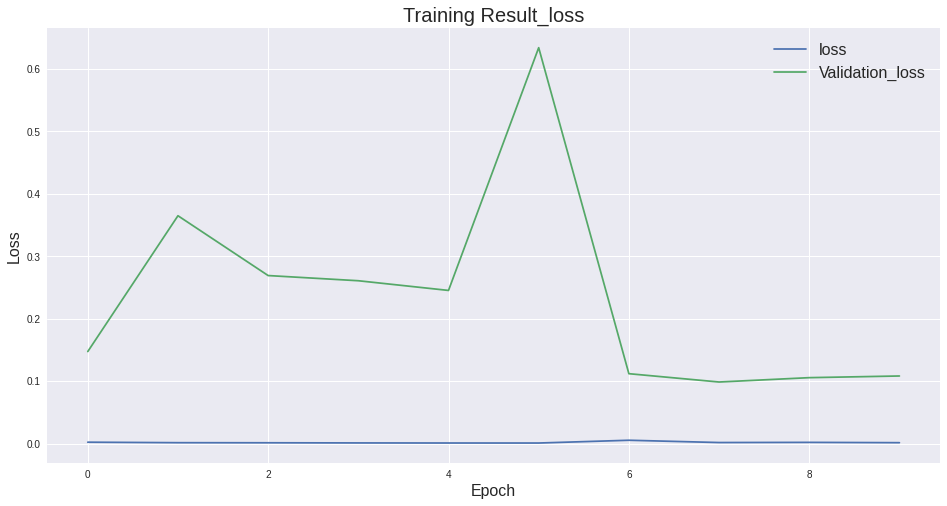

In [49]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Result_loss',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['loss','Validation_loss'], loc='upper right',fontsize=16)
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(Xtest)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(ytest,axis = 1)
cls_report = classification_report(y_true, pred)
# print classification report
print("\n\n")
print("-"*50)
print("Test Performance_SEResNet_Nesterov Adam optimizer")
print("-"*50)
print(cls_report)
print("-"*50)




--------------------------------------------------
Test Performance_SEResNet_Nesterov Adam optimizer
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       270
           1       0.97      0.99      0.98       774

    accuracy                           0.97      1044
   macro avg       0.96      0.95      0.96      1044
weighted avg       0.97      0.97      0.97      1044

--------------------------------------------------


## 5.2 Cosine Annealing

In [0]:
import math
from keras.callbacks import Callback
from keras import backend as K

class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [43]:
callbacks = [CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)]
model.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])
batch_size = 64
epochs = 40
history = model.fit(Xtrain, ytrain, validation_split=0.25, callbacks=callbacks, epochs=epochs)

Train on 3129 samples, validate on 1043 samples
Epoch 1/40
3129/3129 [==============================] - 11s 4ms/step - loss: 0.0510 - accuracy: 0.9863 - val_loss: 0.1289 - val_accuracy: 0.9559
Epoch 2/40
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0267 - accuracy: 0.9949 - val_loss: 1.0474 - val_accuracy: 0.7373
Epoch 3/40
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0356 - accuracy: 0.9907 - val_loss: 1.2530 - val_accuracy: 0.8341
Epoch 4/40
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0391 - accuracy: 0.9898 - val_loss: 1.4658 - val_accuracy: 0.7593
Epoch 5/40
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0263 - accuracy: 0.9926 - val_loss: 0.6261 - val_accuracy: 0.8360
Epoch 6/40
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0321 - accuracy: 0.9923 - val_loss: 0.3508 - val_accuracy: 0.8849
Epoch 7/40
3129/3129 [==============================] - 7s 2ms/step - loss: 0.0196 - ac

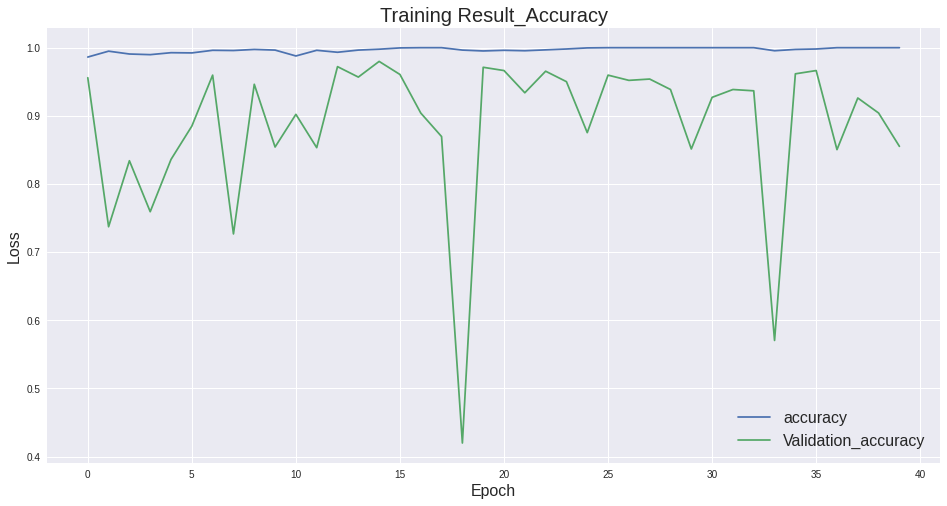

In [44]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Result_Accuracy',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['accuracy','Validation_accuracy'], loc='lower right',fontsize=16)
plt.show()

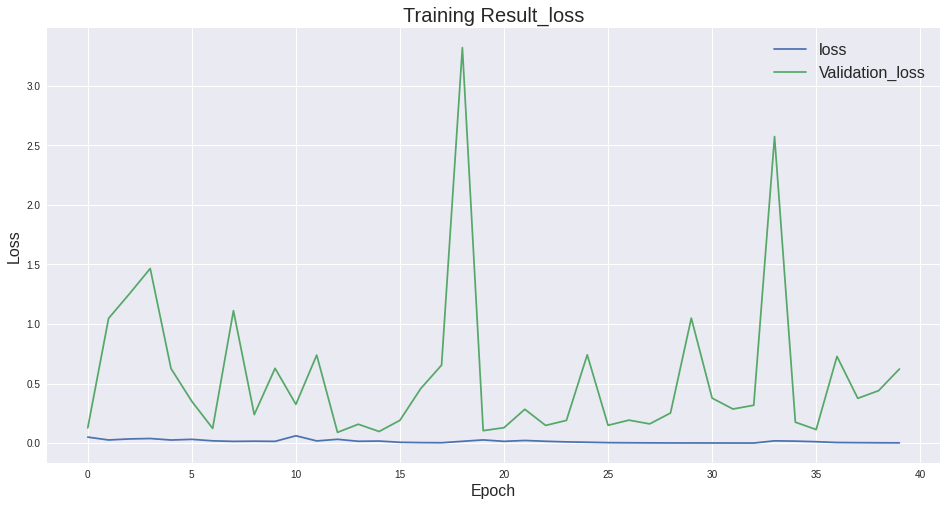

In [45]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Result_loss',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['loss','Validation_loss'], loc='upper right',fontsize=16)
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(Xtest)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(ytest,axis = 1)
cls_report = classification_report(y_true, pred)
# print classification report
print("\n\n")
print("-"*50)
print("Test Performance_SEResNet_Cosine_Annealing")
print("-"*50)
print(cls_report)
print("-"*50)




--------------------------------------------------
Test Performance_SEResNet_Cosine_Annealing
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.45      0.62       270
           1       0.84      1.00      0.91       774

    accuracy                           0.86      1044
   macro avg       0.92      0.73      0.77      1044
weighted avg       0.88      0.86      0.84      1044

--------------------------------------------------
